In [ ]:
# === Cell 0: imports, seed, quick environment check ===
import os, zipfile, math, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

print("TensorFlow:", tf.__version__)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TensorFlow: 2.19.0


In [ ]:
# === Cell 1: Mount Drive & extract dataset ===
# Run if your dataset zip is on Google Drive (you already used this before).
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/archive.zip'    # <-- keep your path
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("Extracted dataset to:", extract_path)
else:
    print("Dataset already present at:", extract_path)

# dataset paths (same as your ResNet code)
dataset_root = '/content/dataset/eye reaction last'
train_path = os.path.join(dataset_root, 'train')
test_path  = os.path.join(dataset_root, 'test')

print("train_path:", train_path)
print("test_path: ", test_path)


Mounted at /content/drive
Extracted dataset to: /content/dataset
train_path: /content/dataset/eye reaction last/train
test_path:  /content/dataset/eye reaction last/test


In [ ]:
# Step 1: Unzip dataset
zip_path = '/content/drive/MyDrive/archive.zip'  # your dataset zip path
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Step 2: Set dataset_dir to the extracted folder containing classes
dataset_dir = '/content/dataset/eye reaction last'

In [ ]:
# Step 3: List class folders inside dataset_dir
print("Classes in dataset directory:")
classes = os.listdir(dataset_dir)
print(classes)


Classes in dataset directory:
['train', 'test']


In [ ]:
# Step 4: Check class distribution by counting files in each class folder
print("\nClass distribution:")
for cls in classes:
    class_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        print(f"Class '{cls}': {num_files} images")

train_path = '/content/dataset/eye reaction last/train'
test_path = '/content/dataset/eye reaction last/test'

print("Train folder contents:", os.listdir(train_path))
print("Test folder contents:", os.listdir(test_path))


Class distribution:
Class 'train': 6 images
Class 'test': 6 images
Train folder contents: ['surprise', 'sad', 'fear', 'happy', 'anger', 'disgust']
Test folder contents: ['surprise', 'sad', 'fear', 'happy', 'anger', 'disgust']


In [ ]:
# === Cell: Directory & image-count checks (run right after your dataset listing) ===
import os
from collections import defaultdict

# update these if your paths differ
train_path = '/content/dataset/eye reaction last/train'
test_path  = '/content/dataset/eye reaction last/test'

def is_image_file(fname):
    return fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))

# check train classes and counts
train_counts = {}
total_train = 0
train_classes = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
print("Train classes:", train_classes)
for c in train_classes:
    p = os.path.join(train_path, c)
    files = [f for f in os.listdir(p) if is_image_file(f)]
    train_counts[c] = len(files)
    total_train += len(files)

# check test classes and counts
test_counts = {}
total_test = 0
test_classes = sorted([d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))])
print("Test classes:", test_classes)
for c in test_classes:
    p = os.path.join(test_path, c)
    files = [f for f in os.listdir(p) if is_image_file(f)]
    test_counts[c] = len(files)
    total_test += len(files)

print("\n Train image counts per class:")
for c, cnt in train_counts.items():
    print(f"  {c}: {cnt}")

print("\n Test image counts per class:")
for c, cnt in test_counts.items():
    print(f"  {c}: {cnt}")

print(f"\nTotal train images: {total_train}")
print(f"Total test  images: {total_test}")


Train classes: ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise']
Test classes: ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise']

 Train image counts per class:
  anger: 45
  disgust: 45
  fear: 45
  happy: 45
  sad: 45
  surprise: 45

 Test image counts per class:
  anger: 27
  disgust: 15
  fear: 23
  happy: 34
  sad: 21
  surprise: 18

Total train images: 270
Total test  images: 138


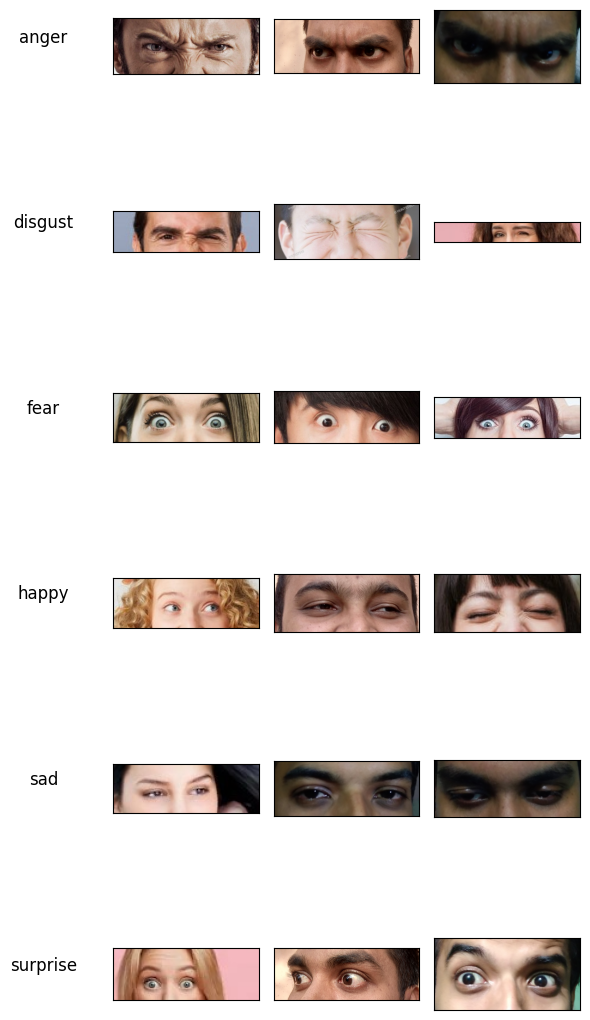

In [ ]:
# === Cell: Visual quick-sample from each class (sanity check) ===
import matplotlib.pyplot as plt
import cv2
import random

SAMPLES_PER_CLASS = 3
plt.figure(figsize=(SAMPLES_PER_CLASS * 2, len(train_classes) * 2))

row = 0
for c in train_classes:
    p = os.path.join(train_path, c)
    imgs = [f for f in os.listdir(p) if is_image_file(f)]
    random.shuffle(imgs)
    for i in range(min(SAMPLES_PER_CLASS, len(imgs))):
        fp = os.path.join(p, imgs[i])
        img = cv2.imread(fp)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(len(train_classes), SAMPLES_PER_CLASS, row * SAMPLES_PER_CLASS + i + 1)
        ax.imshow(img)
        if i == 0:
            ax.set_ylabel(c, rotation=0, labelpad=50, fontsize=12)
        ax.set_xticks([]); ax.set_yticks([])
    row += 1
plt.tight_layout()
plt.show()


In [ ]:
# === Cell: Data Generators ===
BATCH_SIZE = 8
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
y_train_labels = train_gen.classes
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_labels),
                                     y=y_train_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Found 270 images belonging to 6 classes.
Found 138 images belonging to 6 classes.
Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}


In [ ]:
# === Cell: Build MobileNetV2 Model ===
base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # freeze backbone initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(len(train_classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# === Cell: Callbacks ===
checkpoint = ModelCheckpoint('best_mobilenetv2_emotion_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)



In [ ]:
# === Cell: Stage 1 - Train top layers ===
history1 = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.2104 - loss: 2.6177
Epoch 1: val_loss improved from inf to 1.61622, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 901ms/step - accuracy: 0.2108 - loss: 2.6143 - val_accuracy: 0.2899 - val_loss: 1.6162 - learning_rate: 0.0010
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2801 - loss: 1.9608
Epoch 2: val_loss improved from 1.61622 to 1.50492, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.2804 - loss: 1.9596 - val_accuracy: 0.3986 - val_loss: 1.5049 - learning_rate: 0.0010
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4426 - loss: 1.6193
Epoch 3: val_loss improved from 1.50492 to 1.39898, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.4420 - loss: 1.6180 - val_accuracy: 0.4855 - val_loss: 1.3990 - learning_rate: 0.0010
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4780 - loss: 1.4837
Epoch 4: val_loss improved from 1.39898 to 1.31209, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.4770 - loss: 1.4855 - val_accuracy: 0.4203 - val_loss: 1.3121 - learning_rate: 0.0010
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4519 - loss: 1.4992
Epoch 5: val_loss improved from 1.31209 to 1.29703, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.4525 - loss: 1.4995 - val_accuracy: 0.4855 - val_loss: 1.2970 - learning_rate: 0.0010
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4940 - loss: 1.3013
Epoch 6: val_loss improved from 1.29703 to 1.19541, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.4938 - loss: 1.3031 - val_accuracy: 0.4855 - val_loss: 1.1954 - learning_rate: 0.0010
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4865 - loss: 1.3801
Epoch 7: val_loss improved from 1.19541 to 1.15525, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.4861 - loss: 1.3783 - val_accuracy: 0.5580 - val_loss: 1.1553 - learning_rate: 0.0010
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5522 - loss: 1.1832
Epoch 8: val_loss did not improve from 1.15525
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5518 - loss: 1.1842 - val_accuracy: 0.5435 - val_loss: 1.1699 - learning_rate: 0.0010
Epoch 9/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5491 - loss: 1.2306
Epoch 9: val_loss improved from 1.15525 to 1.08360, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.5493 - loss: 1.2291 - val_accuracy: 0.5580 - val_loss: 1.0836 - learning_rate: 0.0010
Epoch 10/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5484 - loss: 1.1871
Epoch 10: val_loss did not improve from 1.08360
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.5491 - loss: 1.1866 - val_accuracy: 0.5217 - val_loss: 1.1043 - learning_rate: 0.0010
Epoch 11/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6329 - loss: 0.9483
Epoch 11: val_loss improved from 1.08360 to 1.05757, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.6320 - loss: 0.9512 - val_accuracy: 0.6449 - val_loss: 1.0576 - learning_rate: 0.0010
Epoch 12/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6434 - loss: 0.8981
Epoch 12: val_loss improved from 1.05757 to 1.02278, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6427 - loss: 0.9005 - val_accuracy: 0.6304 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 13/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6019 - loss: 1.0473
Epoch 13: val_loss improved from 1.02278 to 0.99332, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.6011 - loss: 1.0484 - val_accuracy: 0.6377 - val_loss: 0.9933 - learning_rate: 0.0010
Epoch 14/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6121 - loss: 1.0865
Epoch 14: val_loss did not improve from 0.99332
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6114 - loss: 1.0875 - val_accuracy: 0.5797 - val_loss: 1.1068 - learning_rate: 0.0010
Epoch 15/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6198 - loss: 1.0238
Epoch 15: val_loss did not improve from 0.99332
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.6201 - loss: 1.0231 - val_accuracy: 0.5942 - val_loss: 1.0501 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 13.


In [ ]:
# === Cell: Stage 2 - Fine-tune last 30 layers of MobileNetV2 ===
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

optimizer_finetune = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer_finetune,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3986 - loss: 1.6354
Epoch 1: val_loss did not improve from 0.99332
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 578ms/step - accuracy: 0.4005 - loss: 1.6311 - val_accuracy: 0.5652 - val_loss: 1.1132 - learning_rate: 1.0000e-04
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5670 - loss: 1.1978
Epoch 2: val_loss did not improve from 0.99332
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.5677 - loss: 1.1973 - val_accuracy: 0.5725 - val_loss: 1.0807 - learning_rate: 1.0000e-04
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6255 - loss: 1.0106
Epoch 3: val_loss improved from 0.99332 to 0.94451, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6255 - loss: 1.0124 - val_accuracy: 0.6449 - val_loss: 0.9445 - learning_rate: 1.0000e-04
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6308 - loss: 0.9879
Epoch 4: val_loss improved from 0.94451 to 0.93174, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6318 - loss: 0.9858 - val_accuracy: 0.6594 - val_loss: 0.9317 - learning_rate: 1.0000e-04
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7599 - loss: 0.7437
Epoch 5: val_loss did not improve from 0.93174
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.7593 - loss: 0.7451 - val_accuracy: 0.6522 - val_loss: 1.0573 - learning_rate: 1.0000e-04
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7368 - loss: 0.7469
Epoch 6: val_loss did not improve from 0.93174
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7368 - loss: 0.7463 - val_accuracy: 0.6739 - val_loss: 1.0166 - learning_rate: 1.0000e-04
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7556 - loss: 0.5879
Epoch 7: val_loss improved from 0.93174 to 0.89854, saving model to best_mobilenetv2_emotion_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.7547 - loss: 0.5902 - val_accuracy: 0.7101 - val_loss: 0.8985 - learning_rate: 1.0000e-04
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8142 - loss: 0.5545
Epoch 8: val_loss did not improve from 0.89854
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.8138 - loss: 0.5553 - val_accuracy: 0.7246 - val_loss: 0.9224 - learning_rate: 1.0000e-04
Epoch 9/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8286 - loss: 0.4770
Epoch 9: val_loss did not improve from 0.89854
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.8274 - loss: 0.4807 - val_accuracy: 0.6812 - val_loss: 1.0100 - learning_rate: 1.0000e-04
Epoch 10/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7584 - loss: 0.5973
Epoch 10: val_loss did not improve from 0.89854

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.7587 - loss: 0.5978 - val_accur

In [ ]:
# === Cell: Load best model and evaluate ===
best_model = load_model('best_mobilenetv2_emotion_model.h5')
loss, acc = best_model.evaluate(test_gen)
print(f"\nTest Accuracy: {acc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.7180 - loss: 0.9689

Test Accuracy: 0.7101


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 655ms/step
Accuracy: 0.7101
Precision: 0.7214
Recall: 0.7101
F1 Score: 0.7012
Cohen's Kappa: 0.6486

Classification Report:

              precision    recall  f1-score   support

       anger       0.92      0.85      0.88        27
     disgust       0.57      0.27      0.36        15
        fear       0.74      0.87      0.80        23
       happy       0.75      0.62      0.68        34
         sad       0.67      0.67      0.67        21
    surprise       0.53      0.89      0.67        18

    accuracy                           0.71       138
   macro avg       0.70      0.69      0.68       138
weighted avg       0.72      0.71      0.70       138



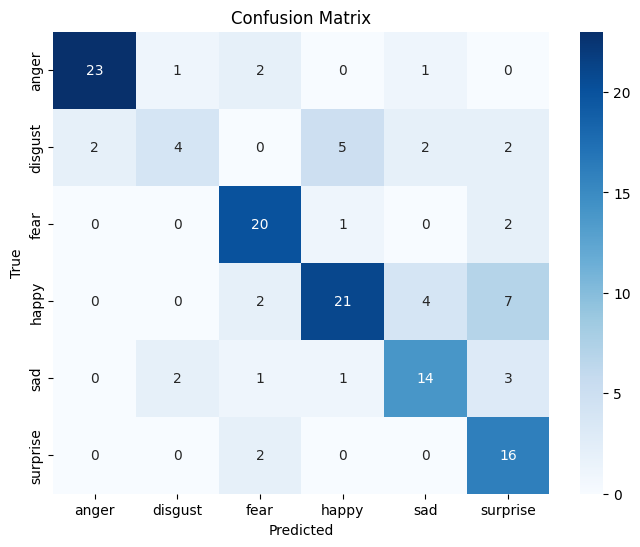

In [ ]:
# ===============================
# Step 5: Evaluation Metrics & Confusion Matrix
# ===============================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test set
test_generator.reset()
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Y_pred_prob = model.predict(test_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Metrics
accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')
f1 = f1_score(Y_true, Y_pred, average='weighted')
kappa = cohen_kappa_score(Y_true, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=class_labels))

# Confusion matrix plot
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


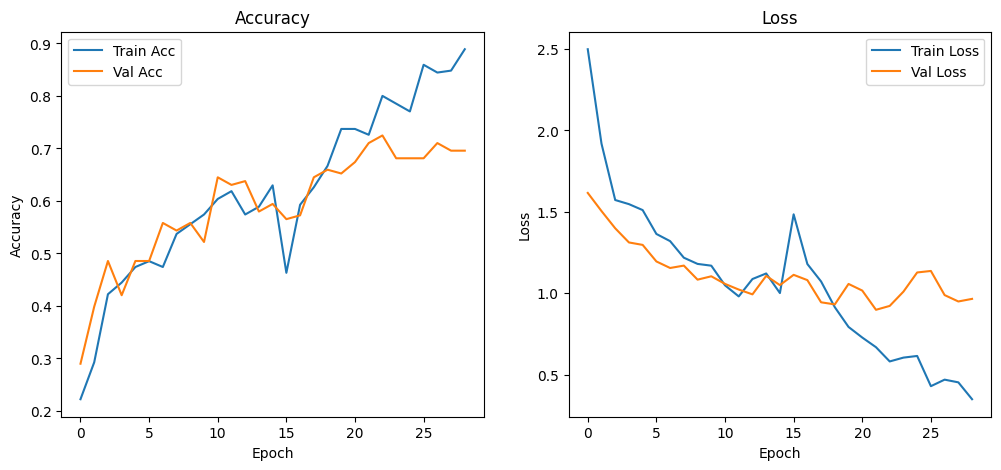

In [ ]:

# === Cell: Plot Accuracy and Loss Curves ===
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history1, history2)

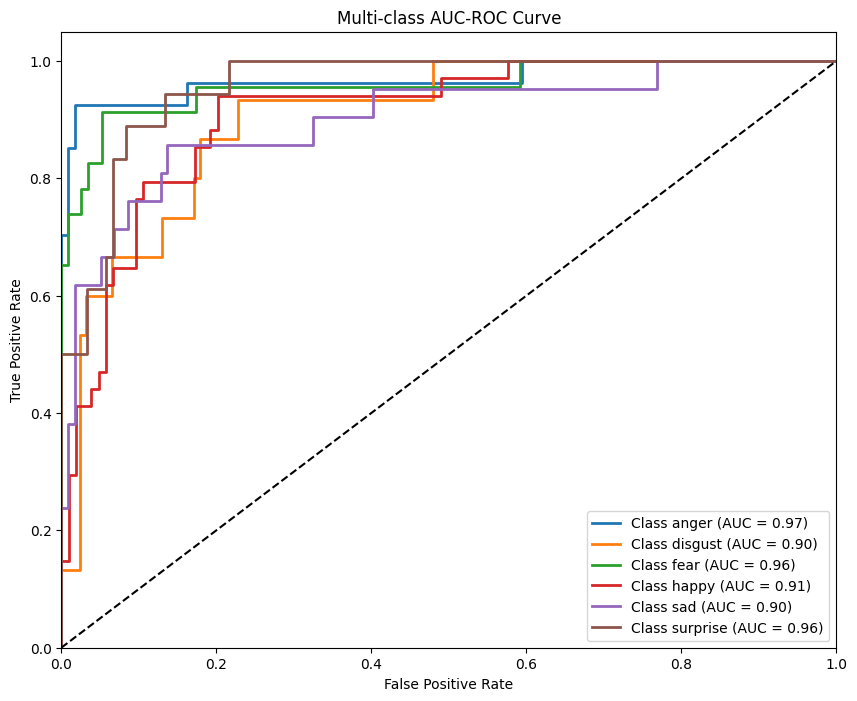

In [ ]:
# ===============================
# Step 7: ROC-AUC for Multi-class
# ===============================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = len(class_labels)

# True labels
y_true = label_binarize(Y_true, classes=list(range(num_classes)))

# ROC-AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], Y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from google.colab import files
import os

# Create folder for unseen images
unseen_dir = "/content/unseen_images"
os.makedirs(unseen_dir, exist_ok=True)

uploaded = files.upload()
image_paths = []
for filename in uploaded.keys():
    filepath = os.path.join(unseen_dir, filename)
    os.rename(filename, filepath)
    image_paths.append(filepath)
print("Uploaded images:", image_paths)


Saving test anger.jpg to test anger.jpg
Saving test disgust.jpg to test disgust.jpg
Saving test fear.jpg to test fear.jpg
Saving test happy.jpg to test happy.jpg
Saving test sad.jpg to test sad.jpg
Saving test surprise.jpg to test surprise.jpg
Uploaded images: ['/content/unseen_images/test anger.jpg', '/content/unseen_images/test disgust.jpg', '/content/unseen_images/test fear.jpg', '/content/unseen_images/test happy.jpg', '/content/unseen_images/test sad.jpg', '/content/unseen_images/test surprise.jpg']


In [ ]:
# Save the trained model
model.save("eye_emotion_MobileNetV2.h5")


In [ ]:
from google.colab import files
files.download("eye_emotion_MobileNetV2.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Update with your dataset classes
class_labels = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise']

def generate_gradcam_mobilenet(model, img_path, last_conv_layer_name='Conv_1', preprocess_func=preprocess_input, img_size=(224,224)):
    """
    Generate Grad-CAM for MobileNetV2
    """
    # Load & preprocess image
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)

    # Predict class
    preds = model.predict(img_array)
    pred_index = np.argmax(preds[0])

    # Grad-CAM model: last conv layer output + model output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    # Weight feature maps
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:,:,i] *= pooled_grads[i]

    # Create heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max() if heatmap.max() != 0 else 1

    # Load original image
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    # Resize heatmap & apply colormap
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

    # Display
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM\nPrediction: {class_labels[pred_index]}")
    plt.axis("off")
    plt.show()

    return preds, class_labels[pred_index]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


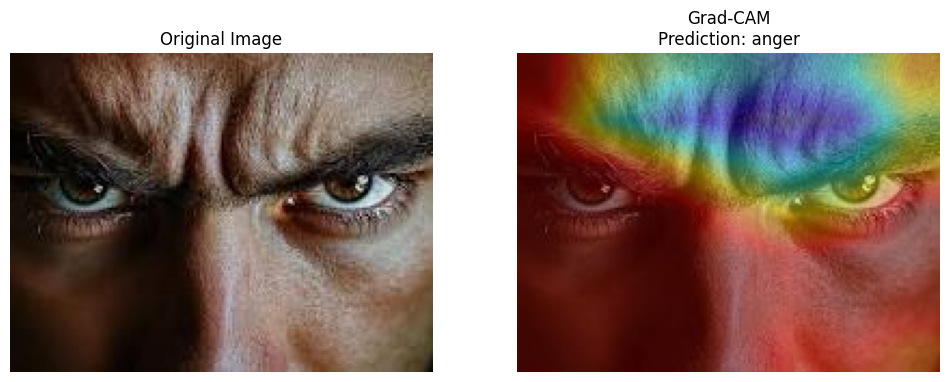

/content/unseen_images/test anger.jpg → Predicted: anger (0.86)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


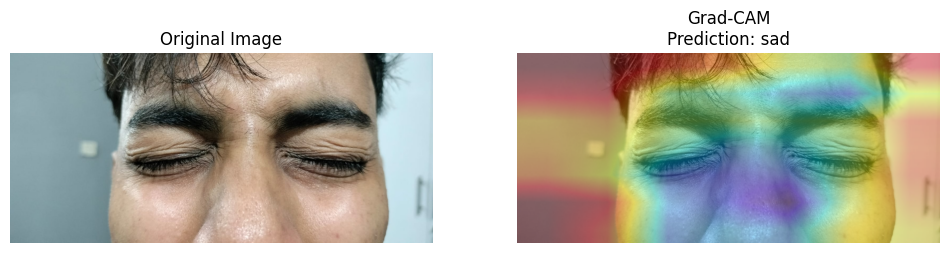

/content/unseen_images/test disgust.jpg → Predicted: sad (0.78)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


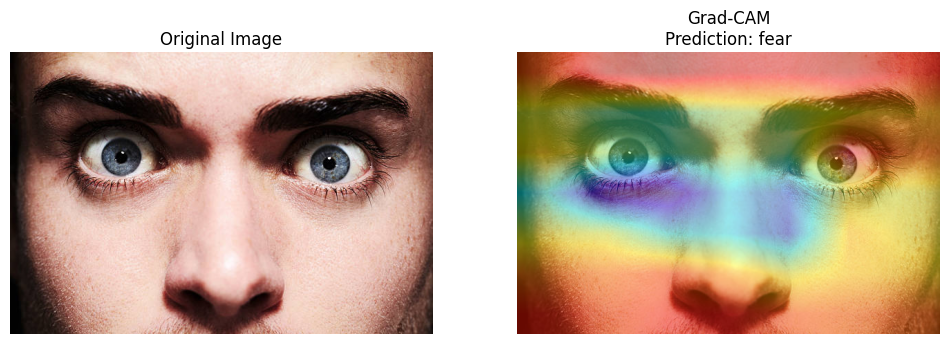

/content/unseen_images/test fear.jpg → Predicted: fear (0.92)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


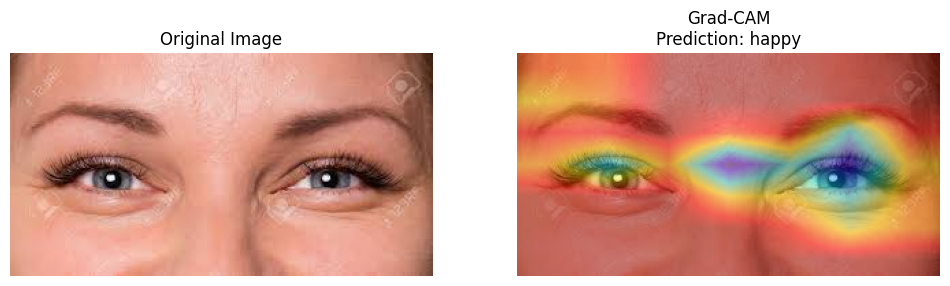

/content/unseen_images/test happy.jpg → Predicted: happy (0.32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


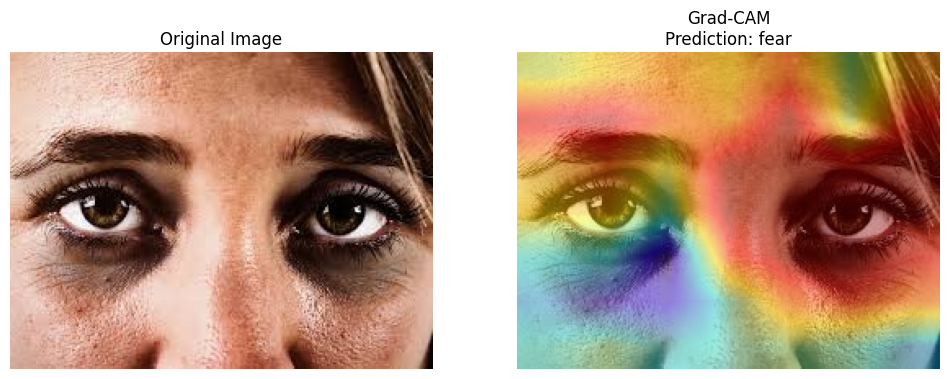

/content/unseen_images/test sad.jpg → Predicted: fear (0.44)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


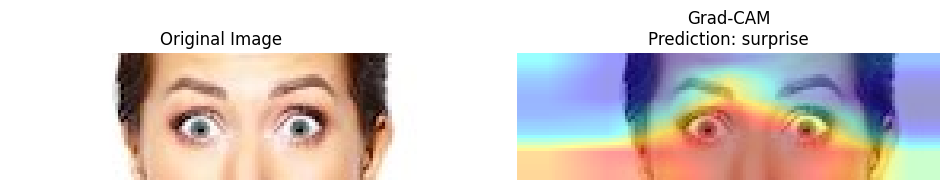

/content/unseen_images/test surprise.jpg → Predicted: surprise (0.85)


In [ ]:
for img_path in image_paths:
    preds, pred_class = generate_gradcam_mobilenet(
        model,
        img_path,
        last_conv_layer_name="Conv_1",  # MobileNetV2 last conv layer
        preprocess_func=preprocess_input,
        img_size=(224,224)
    )
    print(f"{img_path} → Predicted: {pred_class} ({np.max(preds[0]):.2f})")
